# APR Assignment


In [46]:
!pip install kaggle
!kaggle datasets download -d mrsohelranapro/portuguese-bank-marketing-dataset
!mkdir bank_marketing
!tar -xf portuguese-bank-marketing-dataset.zip -C bank_marketing || unzip portuguese-bank-marketing-dataset.zip -d bank_marketing


Dataset URL: https://www.kaggle.com/datasets/mrsohelranapro/portuguese-bank-marketing-dataset
License(s): ODC Attribution License (ODC-By)
portuguese-bank-marketing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


A subdirectory or file bank_marketing already exists.


In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [48]:
CSV_PATH = "bank_marketing/Portuguese Banking-full Dataset.csv"

df = pd.read_csv(CSV_PATH, sep=';')

# Clean column names
df.columns = df.columns.str.replace('"', '').str.strip()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.replace('"', '').str.strip()

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [49]:
# Print 5 random rows from the dataset
random_rows = df.sample(n=5)
random_rows


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
15547,40,entrepreneur,married,secondary,no,1238,yes,no,telephone,21,jul,50,2,-1,0,unknown,no
21511,47,management,married,tertiary,no,0,no,no,cellular,19,aug,213,2,-1,0,unknown,no
11402,51,admin.,married,secondary,no,884,no,no,unknown,19,jun,50,1,-1,0,unknown,no
16259,39,self-employed,married,secondary,no,81,no,yes,cellular,23,jul,438,1,-1,0,unknown,no
14973,59,management,married,tertiary,no,220,yes,no,telephone,16,jul,30,2,-1,0,unknown,no


In [50]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.info()


Dataset shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 n

In [51]:
# Create binary target column
df['y_bin'] = df['y'].map(lambda x: 1 if str(x).lower() in ['yes','1','true'] else 0)

# Replace unknown with NaN and drop
df = df.replace('unknown', np.nan)
df = df.dropna()

print("After dropping 'unknown', shape:", df.shape)
df[['y','y_bin']].head()


After dropping 'unknown', shape: (7842, 18)


,y,y_bin
24060,no,0
24062,yes,1
24064,yes,1
24072,no,0
24077,yes,1


In [52]:
y = df['y_bin'].values
X = df.drop(columns=['y','y_bin'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [53]:
num_df = df[numeric_cols].copy()

means = num_df.mean()
variances = num_df.var(ddof=0)
cov_matrix = num_df.cov()
corr_matrix = num_df.corr()

print("Means:\n", means.head())
print("\nVariances:\n", variances.head())
print("\nCorrelation Matrix (top 5 rows):\n", corr_matrix.head())


Means:
 age           40.783856
balance     1552.343280
day           14.260010
duration     261.290615
campaign       2.064269
dtype: float64

Variances:
 age         1.272890e+02
balance     9.513421e+06
day         6.217047e+01
duration    5.578487e+04
campaign    2.452386e+00
dtype: float64

Correlation Matrix (top 5 rows):
                age   balance       day  duration  campaign     pdays  previous
age       1.000000  0.117283  0.015385  0.058902  0.000736 -0.106095  0.003396
balance   0.117283  1.000000  0.048348  0.040550 -0.011874 -0.101847  0.001708
day       0.015385  0.048348  1.000000 -0.006615 -0.028473 -0.090031 -0.016000
duration  0.058902  0.040550 -0.006615  1.000000 -0.094348 -0.009571 -0.001776
campaign  0.000736 -0.011874 -0.028473 -0.094348  1.000000  0.063530  0.137044


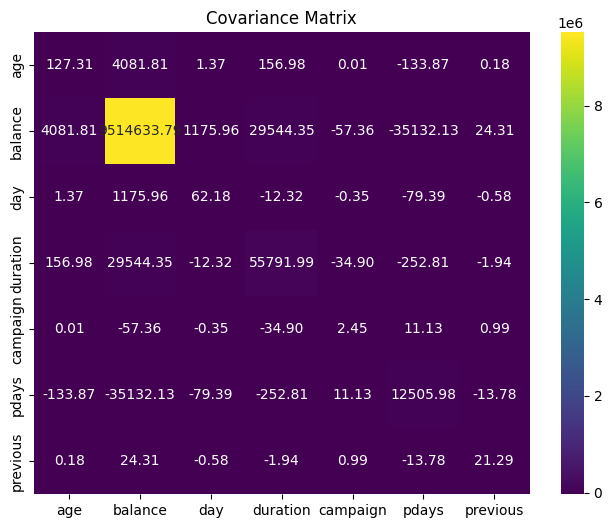

In [54]:
plt.figure(figsize=(8,6))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Covariance Matrix")
plt.show()


In [55]:
sample_numeric = num_df.iloc[:50].values
dist_matrix = squareform(pdist(sample_numeric, metric='euclidean'))

pd.DataFrame(dist_matrix).iloc[:10, :10]


,0,1,2,3,4,5,6,7,8,9
0,0.000000,1226.927463,2564.852822,1534.757636,887.807412,453.592328,710.551898,2287.314801,185.137787,82.625662
1,1226.927463,0.000000,3710.770944,2700.297391,453.015452,1622.957486,651.762994,3379.789638,1298.501829,1189.382193
2,2564.852822,3710.770944,0.000000,1031.463523,3444.396899,2120.181596,3274.729302,445.177493,2440.634344,2572.262234
3,1534.757636,2700.297391,1031.463523,0.000000,2416.601953,1092.008700,2244.346898,814.915947,1416.476262,1544.855333
4,887.807412,453.015452,3444.396899,2416.601953,0.000000,1325.293175,210.276009,3147.466759,1006.175929,873.672135
5,453.592328,1622.957486,2120.181596,1092.008700,1325.293175,0.000000,1157.617381,1840.049728,335.362490,458.094968
6,710.551898,651.762994,3274.729302,2244.346898,210.276009,1157.617381,0.000000,2991.105983,847.850223,708.389017
7,2287.314801,3379.789638,445.177493,814.915947,3147.466759,1840.049728,2991.105983,0.000000,2144.658248,2283.102275
8,185.137787,1298.501829,2440.634344,1416.476262,1006.175929,335.362490,847.850223,2144.658248,0.000000,143.607103
9,82.625662,1189.382193,2572.262234,1544.855333,873.672135,458.094968,708.389017,2283.102275,143.607103,0.000000


In [56]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_cols)
])

X_pre = preprocessor.fit_transform(X)
print("Preprocessed shape:", X_pre.shape)


Preprocessed shape: (7842, 38)


Explained variance ratio: [0.13976383 0.11466584]


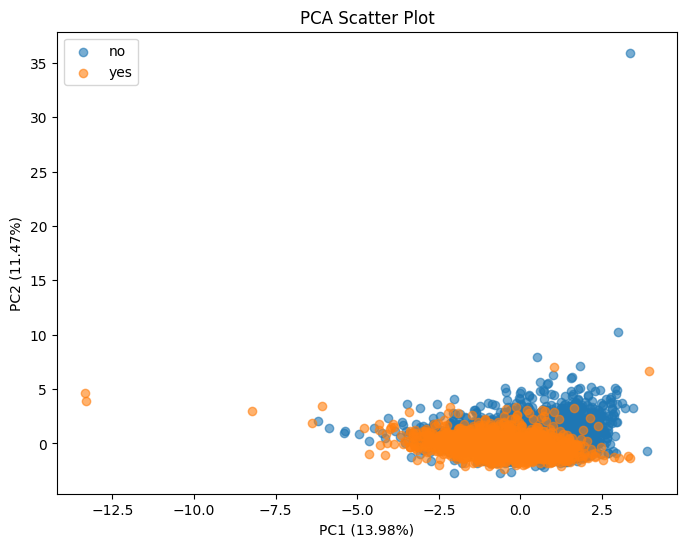

In [57]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pre)

explained = pca.explained_variance_ratio_
print("Explained variance ratio:", explained)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], label='no', alpha=0.6)
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], label='yes', alpha=0.6)
plt.xlabel(f"PC1 ({explained[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({explained[1]*100:.2f}%)")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pre, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5881, 38)
Test shape: (1961, 38)


Classification Report (KNN):

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1514
           1       0.66      0.49      0.56       447

    accuracy                           0.83      1961
   macro avg       0.76      0.71      0.73      1961
weighted avg       0.81      0.83      0.82      1961



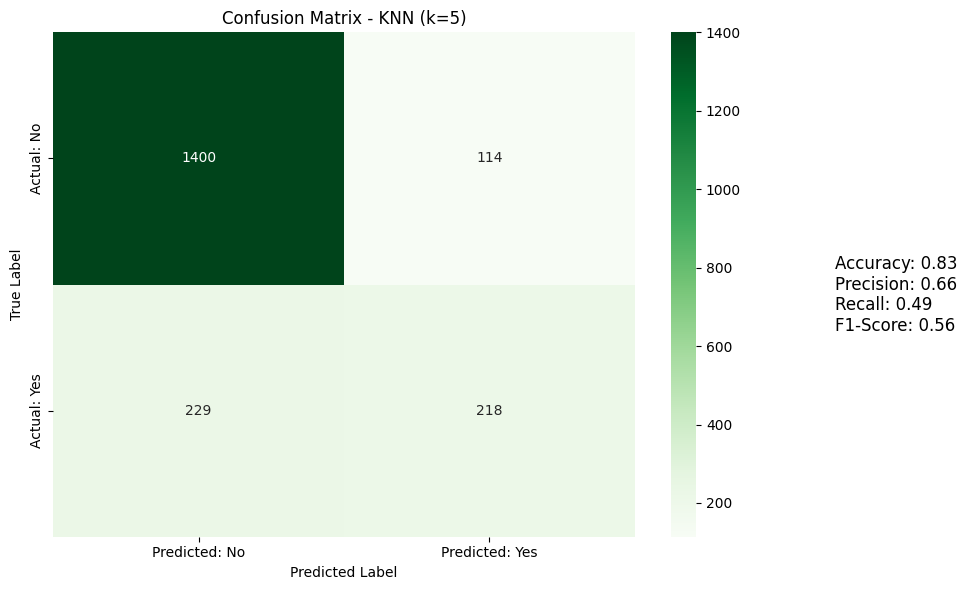

In [64]:
# Create outputs folder if missing
if not os.path.exists("outputs"):
    os.makedirs("outputs")

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)

# Compute metrics
acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn)
rec = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

print("Classification Report (KNN):\n")
print(classification_report(y_test, y_pred_knn)) 

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - KNN (k=5)")

# Add metrics beside the plot
metrics_text = f"Accuracy: {acc:.2f}\nPrecision: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score: {f1:.2f}"
plt.gcf().text(1.05, 0.5, metrics_text, fontsize=12, va='center')

plt.tight_layout()

# Save the figure
plt.savefig("outputs/confusion_matrix_knn.png", bbox_inches='tight')

plt.show()

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

          No       0.94      0.81      0.87      1514
         Yes       0.56      0.81      0.66       447

    accuracy                           0.81      1961
   macro avg       0.75      0.81      0.77      1961
weighted avg       0.85      0.81      0.82      1961



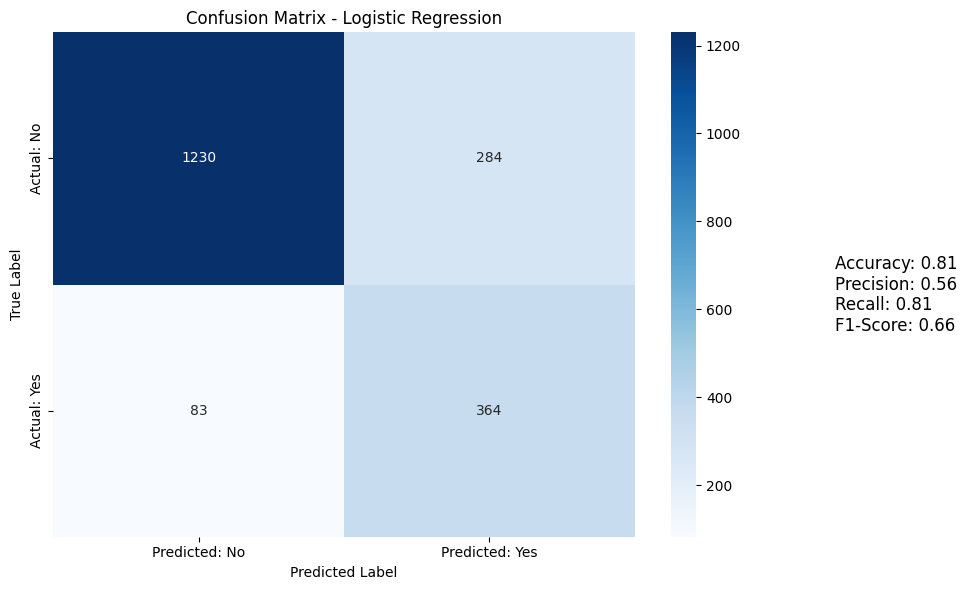

In [65]:
# Train Logistic Regression
logreg = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred_log = logreg.predict(X_test)

# Classification report
print("Classification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_log, target_names=['No','Yes']))

# Compute metrics
acc = accuracy_score(y_test, y_pred_log)
prec = precision_score(y_test, y_pred_log)
rec = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_log)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")

# Add metrics beside the plot
metrics_text = f"Accuracy: {acc:.2f}\nPrecision: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score: {f1:.2f}"
plt.gcf().text(1.05, 0.5, metrics_text, fontsize=12, va='center')

plt.tight_layout()

# Save figure
plt.savefig("outputs/confusion_matrix_logreg.png", bbox_inches='tight')

plt.show()

In [66]:

new_input = {
    'age': 50,
    'job': 'management',
    'marital': 'single',
    'education': 'tertiary',
    'default': 'no',
    'balance': 567,
    'housing': 'yes',
    'loan': 'no',
    'contact': 'cellular',
    'day': 29,
    'month': 'jan',
    'duration': 50,
    'campaign': 1,
    'pdays': 258,
    'previous': 8,
    'poutcome': 'failure'
}

# Convert to DataFrame
new_df = pd.DataFrame([new_input])

# Preprocess using the same preprocessor
new_input_pre = preprocessor.transform(new_df)

# Predict using the trained Logistic Regression model
pred_bin = logreg.predict(new_input_pre)[0]
pred_prob = logreg.predict_proba(new_input_pre)[0][1]  # probability for 'yes'

# Output the prediction
result = 'Yes' if pred_bin == 1 else 'No'
print(f"Predicted outcome: {result}")
print(f"Probability of 'Yes': {pred_prob:.2f}")


Predicted outcome: No
Probability of 'Yes': 0.09
